# Autoencoders: denoising

This notebook includes:
- denoising autoencoders
- latent space distribution with SWAE

**Denoising**
![denoising](https://miro.medium.com/max/5160/1*SxwRp9i23OM0Up4sEze1QQ@2x.png)
Source: https://www.kaggle.com/tarunkr/autoencoder-denoising-image-mnist-cifar10

## Technical imports

In [9]:
import matplotlib.pyplot as plt
import numpy as np

## Data

In [10]:
import torch
from torchvision import transforms
from torchvision.datasets import MNIST

In [11]:
DATASETS_PATH = 'data' # path to directory where data are to be stored

In [12]:
transform = transforms.ToTensor()

In [13]:
mnist_train = MNIST(DATASETS_PATH, train=True, download=True, transform=transform);
mnist_test = MNIST(DATASETS_PATH, train=False, download=True, transform=transform);

In [14]:
batch_size = 128
mnist_train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
mnist_test_dataloader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

In [15]:
img = mnist_train[0][0]

Salt and pepper transform:

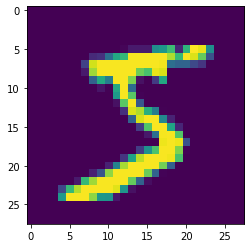

In [16]:
plt.imshow(img[0])

In [20]:
img.shape

torch.Size([1, 28, 28])

In [21]:
batch = next(iter(mnist_train_dataloader))

In [22]:
batch[0].shape

torch.Size([128, 1, 28, 28])

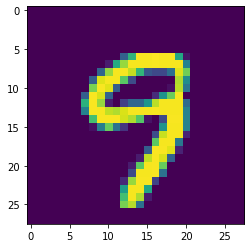

In [23]:
plt.imshow(batch[0][0][0])

In [24]:
def salt_and_pepper(img, noise):
    """img: tensor of size 1 x H x W"
    noise: salt and pepper fraction"""
    # copy tensor
    img_out = img.clone()
    
    N_pixels = img_out.shape[1] * img_out.shape[2]
    # randomly sample indices for salt and pepper
    indices_salt = np.random.choice(np.arange(N_pixels), int(0.5*noise*N_pixels))
    indices_pepper = np.random.choice(np.arange(N_pixels), int(0.5*noise*N_pixels))
    # apply salt and pepper
    img_out[np.unravel_index(indices_salt, img_out.shape)] = 0.0
    img_out[np.unravel_index(indices_pepper, img_out.shape)] = 1.0
    return img_out

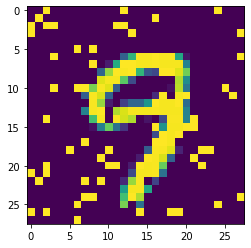

In [25]:
plt.imshow(salt_and_pepper(batch[0][0], 0.2)[0])

In [26]:
class SaltPepper:
    def __init__(self, noise):
        self.noise = noise
    
    def __call__(self, img_or_batch):
        if img_or_batch.ndim == 3:
            is_image=True
            img_or_batch = img_or_batch.unsqueeze(0) # produce "batch" of length 1
        else:
            is_image=False
        
        batch_out = img_or_batch.clone()
    
        N_pixels = batch_out.shape[0] * batch_out.shape[2] * batch_out.shape[3]
        # randomly sample indices for salt and pepper
        indices_salt = np.random.choice(np.arange(N_pixels), int(0.5*self.noise*N_pixels))
        indices_pepper = np.random.choice(np.arange(N_pixels), int(0.5*self.noise*N_pixels))
        # apply salt and pepper
        batch_out[np.unravel_index(indices_salt, batch_out.shape)] = 0.0
        batch_out[np.unravel_index(indices_pepper, batch_out.shape)] = 1.0
        
        if is_image:
            return batch_out.squeeze(0) # return image shape
    
        return batch_out

In [27]:
noise_level = 0.2
salt_pepper_transform = SaltPepper(noise_level)

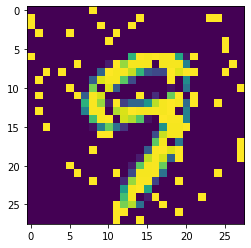

In [28]:
plt.imshow(salt_pepper_transform(batch[0])[0][0], vmin=0, vmax=1)

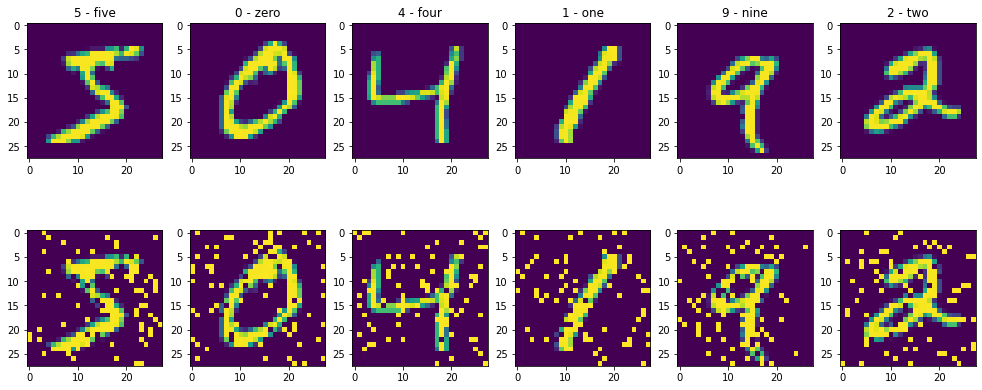

In [29]:
num_images = 6
fig, axs = plt.subplots(ncols=num_images, nrows=2, figsize=(17,7))
for i in range(num_images):
    img, target = mnist_train[i]
    axs[0][i].imshow(img[0])
    axs[0][i].set_title(f'{mnist_train.classes[target]}')
    axs[1][i].imshow(salt_pepper_transform(img)[0])
    
    

In [30]:
class MaskGenerator:
    def __init__(self, scale=4, noise=0.4, fill_value=0.5):
        self.scale = scale
        self.noise = noise
        self.fill_value = fill_value
    
    def __call__(self, img_or_batch):
        if img_or_batch.ndim == 3:
            is_image=True
            img_or_batch = img_or_batch.unsqueeze(0) # produce "batch" of length 1
        else:
            is_image=False
        
        batch_out = img_or_batch.clone()
        batch_size, channels, height, width = batch_out.shape
        
        # be sure that scale if divisor of both height and width
        assert height%self.scale == 0 and width%self.scale == 0
                
        # get random mask
        N_pixels = batch_size * height//self.scale * width//self.scale
        indices_mask = np.random.rand(N_pixels).reshape((batch_out.shape[0], 1, batch_out.shape[2]//self.scale, batch_out.shape[3]//self.scale)) < self.noise
        indices_mask = indices_mask.repeat(self.scale, axis=2).repeat(self.scale, axis=3)
        indices_mask = torch.from_numpy(indices_mask).float().to(img_or_batch.device)

        # apply mask
        batch_out = (1-indices_mask)*batch_out + indices_mask*self.fill_value
        
        if is_image:
            return batch_out.squeeze(0) # return image shape
    
        return batch_out

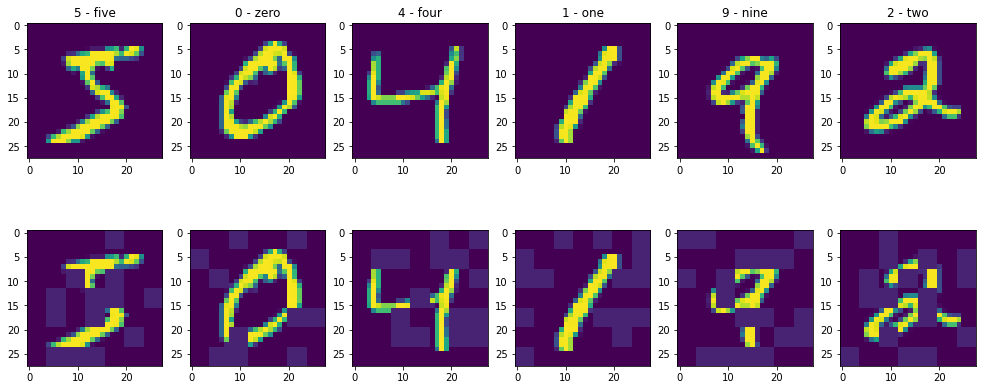

In [33]:
noise_level = 0.3
mask_transform = MaskGenerator(scale=4, noise=noise_level, fill_value=0.1)

num_images = 6
fig, axs = plt.subplots(ncols=num_images, nrows=2, figsize=(17,7))
for i in range(num_images):
    img, target = mnist_train[i]
    axs[0][i].imshow(img[0])
    axs[0][i].set_title(f'{mnist_train.classes[target]}')
    axs[1][i].imshow(mask_transform(img)[0])
    
    

## Model

In [34]:
import torch
from torch import nn

In [35]:
class Encoder_1hl(nn.Module):
    def __init__(self, hidden_dim, latent_dim):
        """
        hidden_dim: number of neurons in the hidden layer
        latent_dim: number of latent space dimensions
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(28*28, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim),
            )

    def forward(self, x):
        x = self.net(x)
        return x

In [36]:
class Decoder_1hl(nn.Module):
    def __init__(self, hidden_dim, latent_dim):
        """
        hidden_dim: number of neurons in the hidden layer
        latent_dim: number of latent space dimensions
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 28*28),
            nn.Sigmoid() # sigmoid function transforms input values (-inf, +inf) to output in range (0, 1)
            )
            

    def forward(self, x):
        x = self.net(x)
        return x

In [37]:
class Autoencoder_1hl(nn.Module):
    def __init__(self, hidden_dim, latent_dim):
        """
        hidden_dim: number of neurons in the hidden layer
        latent_dim: number of latent space dimensions
        """
        super().__init__()
        self.encoder = Encoder_1hl(hidden_dim, latent_dim)
        self.decoder = Decoder_1hl(hidden_dim, latent_dim)
            
    def forward(self, x):
        input_shape = x.shape #batch_size, channels, height, width
        x = x.reshape(input_shape[0], -1)
        z = self.encoder(x)
        x_hat = self.decoder(z) 
        return x_hat.reshape(input_shape), z

In [38]:
hidden_dim = 64
latent_dim = 12

In [39]:
autoencoder = Autoencoder_1hl(hidden_dim, latent_dim)

## Training

In [40]:
noise_level = 0.3

In [42]:
distortion = MaskGenerator(noise=noise_level) #SaltPepper(noise_level)

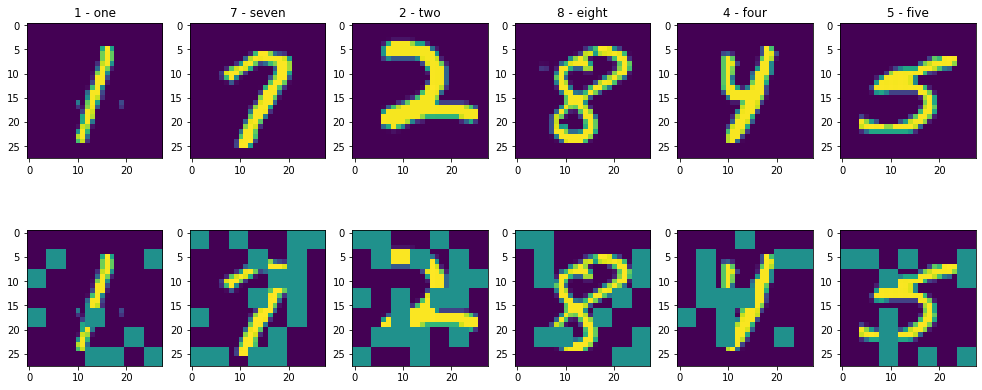

In [43]:
x, y = next(iter(mnist_train_dataloader))
x_distorted = distortion(x)
num_images = 6
fig, axs = plt.subplots(ncols=num_images, nrows=2, figsize=(17,7))
for i in range(num_images):
    axs[0][i].imshow(x[i][0])
    axs[0][i].set_title(f'{mnist_train.classes[y[i]]}')
    axs[1][i].imshow(x_distorted[i][0])


In [44]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # if your machine supports cuda, it wil be used for computation
autoencoder.to(device).train();
optimizer = torch.optim.AdamW(autoencoder.parameters(), lr=1e-3)
criterion = nn.MSELoss()

#### Your task
Can you modify the training loop, so that the model will be train to reconstruct image before distortion?

In [ ]:
num_epochs = 2

history = [] #save losses from each epoch
for i_epoch in range(num_epochs):
    epoch_losses = []
    for batch in mnist_train_dataloader:
         # clear gradient from previous step
        optimizer.zero_grad()
        
        x, y = batch
        # your code here
        ...
        loss = ...
        
        # compute accumulated gradients
        loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # save loss
        epoch_losses.append(loss.item()) #'item()' gets number from tensor. Similarly 'numpy()' returns numpy array copy of the tensor
        
        
    epoch_loss = np.mean(epoch_losses)
    print(f'epoch {i_epoch}, loss: {epoch_loss:0.4f}')
    history.append({'loss': epoch_loss})
        

epoch 0, loss: 0.0239
epoch 1, loss: 0.0236


Solution

In [135]:
num_epochs = 2

history = [] #save losses from each epoch
for i_epoch in range(num_epochs):
    epoch_losses = []
    for batch in mnist_train_dataloader:
         # clear gradient from previous step
        optimizer.zero_grad()
        
        x, y = batch
        x = x.to(device)
        x_hat, z = autoencoder(distortion(x))
        loss = criterion(x, x_hat)
        
        # compute accumulated gradients
        loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # save loss
        epoch_losses.append(loss.item()) #'item()' gets number from tensor. Similarly 'numpy()' returns numpy array copy of the tensor
        
        
    epoch_loss = np.mean(epoch_losses)
    print(f'epoch {i_epoch}, loss: {epoch_loss:0.4f}')
    history.append({'loss': epoch_loss})
        

epoch 0, loss: 0.0637
epoch 1, loss: 0.0402


In [45]:
@torch.no_grad()
def evaluate_model(model, dataloader, criterion, distortion=None, device=device):
    losses = []
    model = model.eval()
    for batch in dataloader:  
        x, y = batch
        x = x.to(device)
        x_hat, z = model(distortion(x))
        loss = criterion(x, x_hat)
        losses.append(loss.item())
    final_loss = np.mean(losses)
    return final_loss

Test if your function works

In [46]:
test_loss = evaluate_model(autoencoder, mnist_test_dataloader, criterion, distortion)
print(f'test loss: {test_loss:0.4f}')

test loss: 0.2309


Now we are ready to implement testset evaluation and do the proper traing of the model. For clarity, let's create a fresh autoencoder

In [47]:
hidden_dim = 64
latent_dim = 12
autoencoder = Autoencoder_1hl(hidden_dim, latent_dim)
autoencoder.to(device).train();

optimizer = torch.optim.AdamW(autoencoder.parameters(), lr=1e-4)

In [48]:
num_epochs = 20

history = [] #save losses from each epoch
for i_epoch in range(num_epochs):
    epoch_losses = []
    for batch in mnist_train_dataloader:
         # clear gradient from previous step
        optimizer.zero_grad()
        
        x, y = batch
        x = x.to(device)
        x_hat, z = autoencoder(distortion(x))
        loss = criterion(x, x_hat)
        
        # compute accumulated gradients
        loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # save loss
        epoch_losses.append(loss.item()) #'item()' gets number from tensor. Similarly 'numpy()' returns numpy array copy of the tensor
        
        
    epoch_loss = np.mean(epoch_losses)
    test_loss = evaluate_model(autoencoder, mnist_test_dataloader, criterion, distortion)
    autoencoder.train() # if "evaluate_model" switches the model to 'eval' mode, switch it back 'train'
    print(f'epoch {i_epoch}, train loss: {epoch_loss:0.4f}, test loss {test_loss:0.4f}')
    history.append({'train loss': epoch_loss, 'test loss': test_loss})
        

epoch 0, train loss: 0.1078, test loss 0.0688
epoch 1, train loss: 0.0658, test loss 0.0627
epoch 2, train loss: 0.0604, test loss 0.0573
epoch 3, train loss: 0.0543, test loss 0.0514
epoch 4, train loss: 0.0494, test loss 0.0471
epoch 5, train loss: 0.0458, test loss 0.0442
epoch 6, train loss: 0.0438, test loss 0.0428
epoch 7, train loss: 0.0427, test loss 0.0416
epoch 8, train loss: 0.0415, test loss 0.0405
epoch 9, train loss: 0.0403, test loss 0.0394
epoch 10, train loss: 0.0393, test loss 0.0384
epoch 11, train loss: 0.0384, test loss 0.0375
epoch 12, train loss: 0.0375, test loss 0.0366
epoch 13, train loss: 0.0367, test loss 0.0358
epoch 14, train loss: 0.0359, test loss 0.0351
epoch 15, train loss: 0.0352, test loss 0.0344
epoch 16, train loss: 0.0346, test loss 0.0338
epoch 17, train loss: 0.0340, test loss 0.0333
epoch 18, train loss: 0.0335, test loss 0.0328
epoch 19, train loss: 0.0330, test loss 0.0324


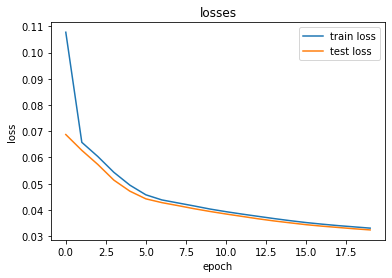

In [54]:
plt.plot([entry['train loss'] for entry in history], label='train loss')
plt.plot([entry['test loss'] for entry in history], label='test loss')
plt.title('losses');
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

For inference on small samples, we can use CPU - it allows to not care about 'cuda' stuff. If the models or images are large, better stay with GPU.

In [55]:
autoencoder.to('cpu').eval();

In [56]:
def reconstruct_image(img, model):
    with torch.no_grad():
        return model(img.unsqueeze(0))[0][0]

In [57]:
img, target = mnist_test[0]
img_distorted = distortion(img.unsqueeze(0)).squeeze(0)
reconstruction = reconstruct_image(img_distorted, autoencoder)

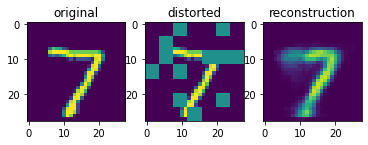

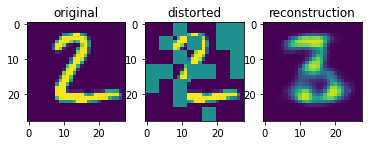

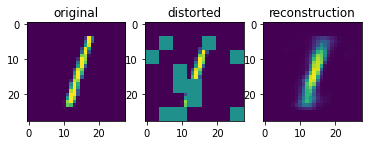

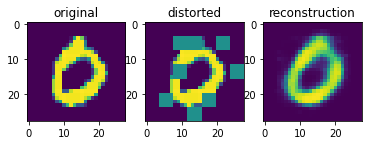

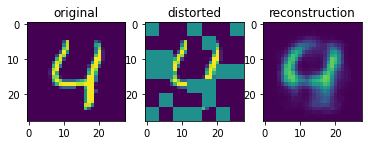

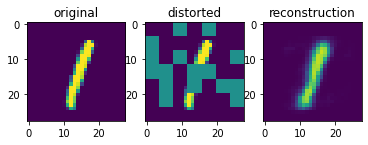

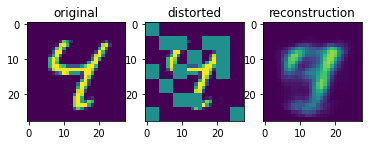

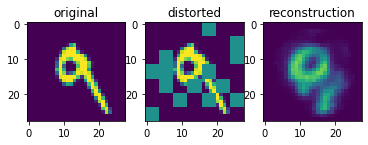

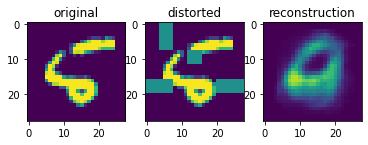

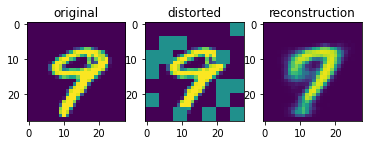

In [58]:
for i in range(10):
    img, target = mnist_test[i]
    img_distorted = distortion(img.unsqueeze(0)).squeeze(0)
    reconstruction = reconstruct_image(img_distorted, autoencoder)
    fig, axs = plt.subplots(ncols=3)
    axs[0].imshow(img[0], vmin=0, vmax=1)
    axs[0].set_title('original')
    axs[1].imshow(img_distorted[0], vmin=0, vmax=1)
    axs[1].set_title('distorted')
    axs[2].imshow(reconstruction[0], vmin=0, vmax=1)
    axs[2].set_title('reconstruction')

## Robustness to noise

In [85]:
noise_levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

In [ ]:
autoencoder = autoencoder.to(device);

In [ ]:
loss_for_noise = {}
for noise_level in noise_levels:
    distortion = MaskGenerator(noise=noise_level)
    loss_for_noise[noise_level] = evaluate_model(autoencoder, mnist_test_dataloader, criterion, distortion)

In [ ]:
for noise_level, loss in loss_for_noise.items():
    print(f'noise: {noise_level}, loss: {loss:0.4f}')

In [ ]:
plt.plot(noise_levels, [loss_for_noise[noise] for noise in noise_levels]);
plt.xlabel('noise level');
plt.ylabel('loss');

Now let's try robustness to Gaussian noise, for which the model wasn't trained for

In [42]:
class GaussianNoise:
    def __init__(self, noise):
        self.noise = noise
    
    def __call__(self, img_or_batch):
        if img_or_batch.ndim == 3:
            is_image=True
            img_or_batch = img_or_batch.unsqueeze(0) # produce "batch" of length 1
        else:
            is_image=False
        
        batch_out = img_or_batch.clone()
        
        noise = torch.randn(batch_out.shape) * self.noise #create noise sampled from normal distribution
        
        batch_out = batch_out + noise.to(batch_out) # add noise
        batch_out = torch.clip(batch_out, 0, 1) #keep values between 0 and 1
        
        if is_image:
            return batch_out.squeeze(0) # return image shape
    
        return batch_out
    

Test Gaussian distortion:

In [43]:
gaussian_distorition = GaussianNoise(0.1)
batch = next(iter(mnist_train_dataloader))

In [44]:
img = batch[0][0]
distorted_image = gaussian_distorition(img)

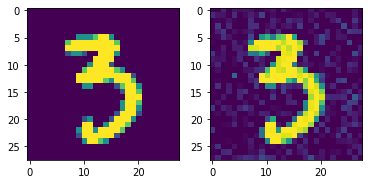

In [45]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(img[0])
ax2.imshow(distorted_image[0])

In [46]:
gaussian_loss_for_noise = {}
for noise_level in noise_levels:
    distortion = GaussianNoise(noise_level)
    gaussian_loss_for_noise[noise_level] = evaluate_model(autoencoder, mnist_test_dataloader, criterion, distortion)

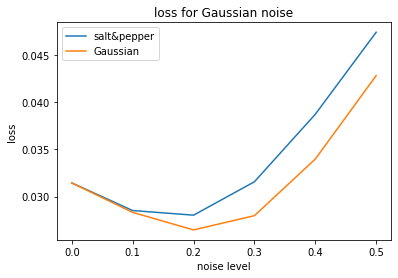

In [47]:
plt.plot(noise_levels, [loss_for_noise[noise] for noise in noise_levels], label='salt&pepper');
plt.plot(noise_levels, [gaussian_loss_for_noise[noise] for noise in noise_levels], label='Gaussian');
plt.xlabel('noise level');
plt.ylabel('loss');
plt.title('loss for Gaussian noise');
plt.legend();

# Latent space distribution

Latent space distribution can be altered by adding loss function on representations `z`. In Variational Autoencoders Normal distribution is imposed by Kullback–Leibler divergence (KL divergence). ["Sliced-Wasserstein Autoencoder: An Embarrassingly Simple Generative Model"](https://arxiv.org/abs/1804.01947) introduces another, more general way, which is used below

In [62]:
# @title functions definitions for SWAE
def rand_ring_nd(batch_size, ndim):
    """ This function generates ndim-dimensional samples from a hollowed-circle distribution in a 2-dimensional space.
        Args:
            batch_size (int): number of batch samples
            ndim (int): number of dimensions
        Return:
            torch.Tensor: tensor of size (batch_size, ndim)
        
        method from http://extremelearning.com.au/how-to-generate-uniformly-random-points-on-n-spheres-and-n-balls/
    """
    x = np.random.normal(size=(batch_size, ndim)) 
    x /= np.linalg.norm(x, axis=1, keepdims=True)
    return torch.from_numpy(x).type(torch.FloatTensor)
  
def rand_ball_nd(batch_size, ndim):
    """ This function generates ndim-dimensional samples from a filled-circle distribution in a 2-dimensional space.
        Args:
            batch_size (int): number of batch samples
            ndim (int): number of dimensions
        Return:
            torch.Tensor: tensor of size (batch_size, ndim)

        method from http://extremelearning.com.au/how-to-generate-uniformly-random-points-on-n-spheres-and-n-balls/
    """
    x = rand_ring_nd(batch_size, ndim+1) 
    return x[:,:-1]



def rand_projections(embedding_dim, num_samples=50):
    """This function generates `num_samples` random samples from the latent space's unit sphere.
        Args:
            embedding_dim (int): embedding dimensionality
            num_samples (int): number of random projection samples
        Return:
            torch.Tensor: tensor of size (num_samples, embedding_dim)
    """
    projections = [w / np.sqrt((w**2).sum())  # L2 normalization
                   for w in np.random.normal(size=(num_samples, embedding_dim))]
    projections = np.asarray(projections)
    return torch.from_numpy(projections).type(torch.FloatTensor)

def _sliced_wasserstein_distance(encoded_samples,
                                 distribution_samples,
                                 num_projections=50,
                                 p=2,
                                 device='cpu'):
    """ Sliced Wasserstein Distance between encoded samples and drawn distribution samples.
        Args:
            encoded_samples (toch.Tensor): tensor of encoded training samples
            distribution_samples (torch.Tensor): tensor of drawn distribution training samples
            num_projections (int): number of projections to approximate sliced wasserstein distance
            p (int): power of distance metric
            device (torch.device): torch device (default 'cpu')
        Return:
            torch.Tensor: tensor of wasserstrain distances of size (num_projections, 1)
    """
    # derive latent space dimension size from random samples drawn from latent prior distribution
    embedding_dim = distribution_samples.size(1)
    # generate random projections in latent space
    projections = rand_projections(embedding_dim, num_projections).to(device)
    # calculate projections through the encoded samples
    encoded_projections = encoded_samples.matmul(projections.transpose(0, 1))
    # calculate projections through the prior distribution random samples
    distribution_projections = (distribution_samples.matmul(projections.transpose(0, 1)))
    # calculate the sliced wasserstein distance by
    # sorting the samples per random projection and
    # calculating the difference between the
    # encoded samples and drawn random samples
    # per random projection
    wasserstein_distance = (torch.sort(encoded_projections.transpose(0, 1), dim=1)[0] -
                            torch.sort(distribution_projections.transpose(0, 1), dim=1)[0])
    # distance between latent space prior and encoded distributions
    # power of 2 by default for Wasserstein-2
    wasserstein_distance = torch.pow(wasserstein_distance, p)
    # approximate mean wasserstein_distance for each projection
    return wasserstein_distance.mean()


def sliced_wasserstein_distance(encoded_samples,
                                distribution_fn,
                                num_projections=50,
                                p=2,
                                device='cpu'):
    """ Sliced Wasserstein Distance between encoded samples and drawn distribution samples.
        Args:
            encoded_samples (toch.Tensor): tensor of encoded training samples
            distribution_samples (torch.Tensor): tensor of drawn distribution training samples
            num_projections (int): number of projections to approximate sliced wasserstein distance
            p (int): power of distance metric
            device (torch.device): torch device (default 'cpu')
        Return:
            torch.Tensor: tensor of wasserstrain distances of size (num_projections, 1)
    """
    # derive batch size from encoded samples
    batch_size = encoded_samples.size(0)
    # draw random samples from latent space prior distribution
    z = distribution_fn(batch_size).to(device)
    # approximate mean wasserstein_distance between encoded and prior distributions
    # for each random projection
    swd = _sliced_wasserstein_distance(encoded_samples, z,
                                       num_projections, p, device)
    return swd

In [63]:
from functools import partial

In [64]:
hidden_dim = 64
latent_dim = 12
autoencoder_swae = Autoencoder_1hl(hidden_dim, latent_dim)
autoencoder_swae.to(device).train();

optimizer = torch.optim.AdamW(autoencoder_swae.parameters(), lr=1e-4)

In [65]:
num_epochs = 20

required_distribution = partial(rand_ball_nd, ndim=latent_dim)
distribution_criterion = partial(sliced_wasserstein_distance, distribution_fn=required_distribution, p=latent_dim, device=device)
distribution_weight = 10

no_distortion = lambda x: x #we want to use evaluate_model function which requires distortion fuction. Mock it with identity function

history = [] #save losses from each epoch
for i_epoch in range(num_epochs):
    epoch_losses = []
    epoch_reconstruction_losses = []
    epoch_distribution_losses = []
    for batch in mnist_train_dataloader:
         # clear gradient from previous step
        optimizer.zero_grad()
        
        x, y = batch
        x = x.to(device)
        x_hat, z = autoencoder_swae(x)
        reconstruction_loss = criterion(x, x_hat)
        distribution_loss = distribution_weight*distribution_criterion(z)
        loss = reconstruction_loss + distribution_loss
        
        # compute accumulated gradients
        loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # save loss
        epoch_reconstruction_losses.append(reconstruction_loss.item())
        epoch_distribution_losses.append(distribution_loss.item())
        epoch_losses.append(loss.item()) #'item()' gets number from tensor. Similarly 'numpy()' returns numpy array copy of the tensor
        
    epoch_reconstruction_loss = np.mean(epoch_reconstruction_losses)
    epoch_distribution_loss = np.mean(epoch_distribution_losses)    
    epoch_loss = np.mean(epoch_losses)
    test_loss = evaluate_model(autoencoder_swae, mnist_test_dataloader, criterion, distortion=no_distortion)
    autoencoder_swae.train() # if "evaluate_model" switches the model to 'eval' mode, switch it back 'train'
    print(f'epoch {i_epoch+1}/{num_epochs}, train loss: {epoch_loss:0.4f}, test loss {test_loss:0.4f}')
    history.append({'train loss': epoch_loss, 'test loss': test_loss, 
                    'train_reconstruction_loss': epoch_reconstruction_loss, 'train_distribution_loss': epoch_distribution_loss})
        

epoch 1/20, train loss: 0.1728, test loss 0.1035
epoch 2/20, train loss: 0.0836, test loss 0.0680
epoch 3/20, train loss: 0.0646, test loss 0.0587
epoch 4/20, train loss: 0.0569, test loss 0.0533
epoch 5/20, train loss: 0.0523, test loss 0.0492
epoch 6/20, train loss: 0.0488, test loss 0.0464
epoch 7/20, train loss: 0.0458, test loss 0.0436
epoch 8/20, train loss: 0.0434, test loss 0.0414
epoch 9/20, train loss: 0.0412, test loss 0.0395
epoch 10/20, train loss: 0.0395, test loss 0.0381
epoch 11/20, train loss: 0.0380, test loss 0.0367
epoch 12/20, train loss: 0.0366, test loss 0.0351
epoch 13/20, train loss: 0.0352, test loss 0.0337
epoch 14/20, train loss: 0.0339, test loss 0.0324
epoch 15/20, train loss: 0.0327, test loss 0.0314
epoch 16/20, train loss: 0.0316, test loss 0.0305
epoch 17/20, train loss: 0.0307, test loss 0.0298
epoch 18/20, train loss: 0.0300, test loss 0.0291
epoch 19/20, train loss: 0.0295, test loss 0.0286
epoch 20/20, train loss: 0.0290, test loss 0.0282


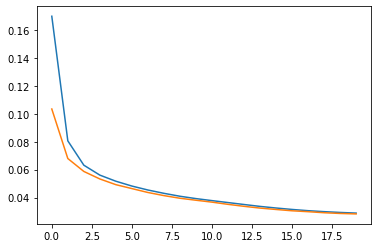

In [66]:
plt.plot([h['train_reconstruction_loss'] for h in history])
plt.plot([h['test loss'] for h in history])

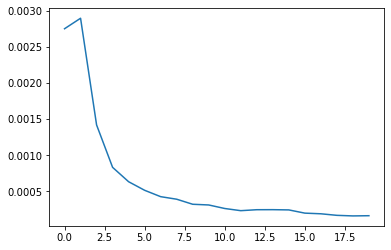

In [67]:
plt.plot([h['train_distribution_loss'] for h in history])

Does autoencoer work?

In [68]:
autoencoder_swae.eval().to('cpu');

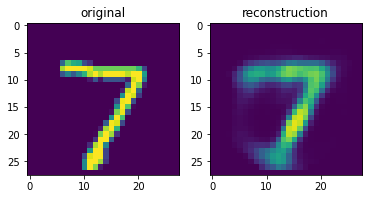

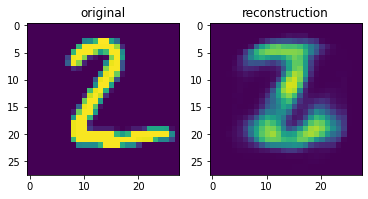

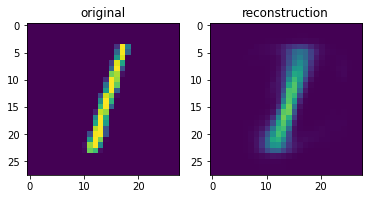

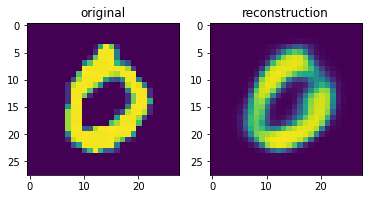

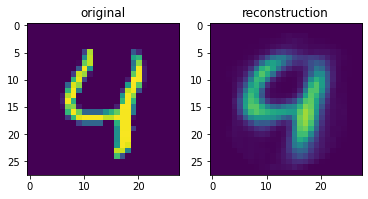

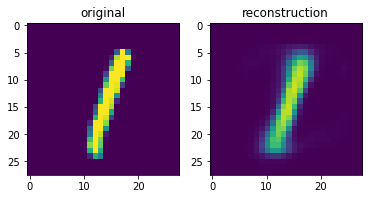

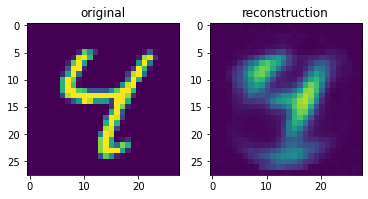

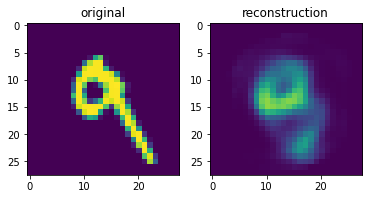

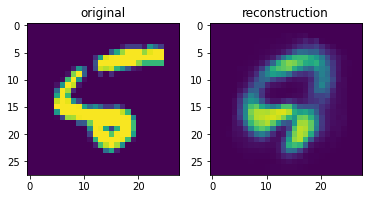

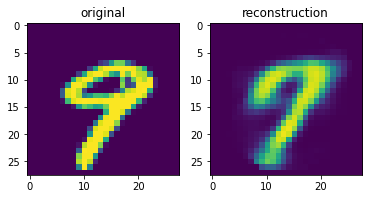

In [69]:
for i in range(10):
    img, target = mnist_test[i]
    reconstruction = reconstruct_image(img, autoencoder_swae)
    fig, axs = plt.subplots(ncols=2)
    axs[0].imshow(img[0], vmin=0, vmax=1)
    axs[0].set_title('original')

    axs[1].imshow(reconstruction[0], vmin=0, vmax=1)
    axs[1].set_title('reconstruction')

Let's see if restriction on latent space works

In [70]:
@torch.no_grad()
def encode_image(img, model, device='cpu'):
  x_hat, z = model(img.unsqueeze(0).to(device))
  return z[0].to('cpu') # "[0]" beacuse 1st item of batch

In [71]:
train_embeddings = []
for idx in range(100):
  img, _ = mnist_train[idx]
  embedding = encode_image(img, autoencoder_swae)
  train_embeddings.append(embedding.numpy())
train_embeddings = np.array(train_embeddings)

In [72]:
test_embeddings = []
for idx in range(100):
  img, _ = mnist_test[idx]
  embedding = encode_image(img, autoencoder_swae)
  test_embeddings.append(embedding.numpy())
test_embeddings = np.array(test_embeddings)

In [73]:
autoencoder.eval().cpu();

In [74]:
test_embeddings_control = []
for idx in range(100):
  img, _ = mnist_test[idx]
  embedding = encode_image(img, autoencoder)
  test_embeddings_control.append(embedding.numpy())
test_embeddings_control = np.array(test_embeddings_control)

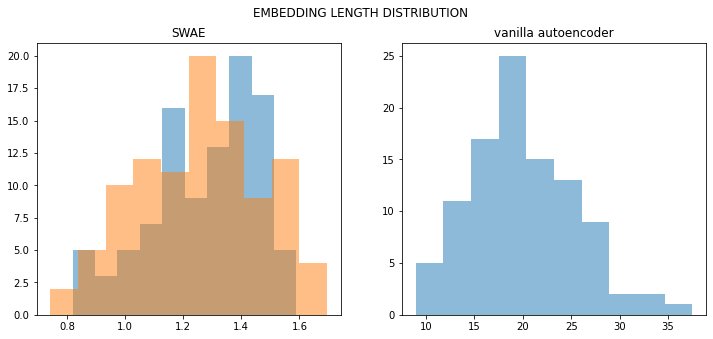

In [83]:
fig, axs = plt.subplots(ncols=2, figsize=(12,5))
axs[0].hist(np.linalg.norm(train_embeddings, axis=1), alpha=0.5)
axs[0].hist(np.linalg.norm(test_embeddings, axis=1), alpha=0.5)
axs[0].set_title('SWAE')
axs[1].hist(np.linalg.norm(test_embeddings_control, axis=1), alpha=0.5)
axs[1].set_title('vanilla autoencoder')
fig.suptitle('EMBEDDING LENGTH DISTRIBUTION');


(array([  1.,   2.,   6.,   7.,  10.,  26.,  49.,  90., 144., 665.]),
 array([0.61933494, 0.65740144, 0.6954679 , 0.7335344 , 0.77160084,
        0.80966735, 0.84773386, 0.8858003 , 0.9238668 , 0.96193326,
        0.99999976], dtype=float32),
 <BarContainer object of 10 artists>)

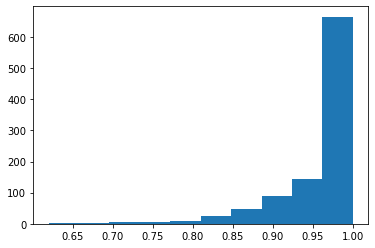

In [84]:
plt.hist(np.linalg.norm(rand_ball_nd(1000,12).numpy(), axis=1))